# Perturbation Dimension Analysis

This notebook analyzes the impact of perturbation dimensions (1-7) on wavelength selection quality and accuracy.

## Objectives
1. Compare best accuracy across perturbation dimensions
2. Analyze tolerance regions for acceptable accuracy levels
3. Understand the relationship between perturbation dimensions and selection quality
4. Visualize trade-offs between feature reduction and accuracy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Data Loading Utilities

In [2]:
# Base path to validation results
BASE_PATH = Path(r'C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results_v2')
OUTPUT_PATH = Path(r'C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\perturbation_dimension_analysis\figures')
OUTPUT_PATH.mkdir(exist_ok=True)

# Dimension levels to analyze
DIMENSION_LEVELS = [1, 2, 3, 4, 5, 6, 7]

In [3]:
def load_results_for_dimension(dim: int) -> pd.DataFrame:
    """
    Load the wavelength_selection_results_v2.xlsx for a specific dimension.
    
    Args:
        dim: Perturbation dimension level (1-7)
    
    Returns:
        DataFrame with results for that dimension
    """
    path = BASE_PATH / f"{dim}Dimensions" / "wavelength_selection_results_v2.xlsx"
    df = pd.read_excel(path, sheet_name='Results_V2')
    df['perturbation_dim'] = dim
    return df

def load_all_results() -> pd.DataFrame:
    """
    Load results from all dimension levels and combine into single DataFrame.
    
    Returns:
        Combined DataFrame with all results
    """
    dfs = []
    for dim in DIMENSION_LEVELS:
        df = load_results_for_dimension(dim)
        dfs.append(df)
    
    combined = pd.concat(dfs, ignore_index=True)
    return combined

def get_baseline_accuracy(df: pd.DataFrame) -> float:
    """
    Extract baseline accuracy from the BASELINE_FULL_DATA entry.
    
    Args:
        df: DataFrame containing results
    
    Returns:
        Baseline accuracy value
    """
    baseline_rows = df[df['config_name'] == 'BASELINE_FULL_DATA']
    if len(baseline_rows) > 0:
        return baseline_rows.iloc[0]['accuracy']
    return None

def extract_n_bands_from_config(config_name: str) -> int:
    """
    Extract number of bands from config name.
    
    Args:
        config_name: Configuration name (e.g., 'mmr_lambda050_variance_1dim_140bands')
    
    Returns:
        Number of bands or None for baseline
    """
    if 'BASELINE' in config_name:
        return 204  # Full data
    
    try:
        # Extract number before 'bands'
        parts = config_name.split('_')
        for part in parts:
            if 'bands' in part:
                return int(part.replace('bands', ''))
    except:
        return None
    return None

In [4]:
# Load all data
print("Loading data from all perturbation dimension levels...")
all_results = load_all_results()

# Extract number of bands for each config
all_results['n_bands'] = all_results['config_name'].apply(extract_n_bands_from_config)

# Get baseline accuracy
baseline_accuracy = get_baseline_accuracy(all_results)
print(f"\nBaseline accuracy: {baseline_accuracy:.4f}")
print(f"\nTotal records loaded: {len(all_results)}")
print(f"Perturbation dimensions: {sorted(all_results['perturbation_dim'].unique())}")

# Show sample
print("\nSample of data:")
all_results[['config_name', 'perturbation_dim', 'n_bands', 'accuracy', 'n_features']].head(10)

Loading data from all perturbation dimension levels...

Baseline accuracy: 0.8554

Total records loaded: 308
Perturbation dimensions: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]

Sample of data:


,config_name,perturbation_dim,n_bands,accuracy,n_features
0,mmr_lambda050_variance_1dim_140bands,1,140,0.878867,140
1,mmr_lambda050_variance_1dim_130bands,1,130,0.877874,130
2,mmr_lambda050_variance_1dim_120bands,1,120,0.877838,120
3,mmr_lambda050_variance_1dim_100bands,1,100,0.877369,100
4,mmr_lambda050_variance_1dim_150bands,1,150,0.876170,150
5,mmr_lambda050_variance_1dim_110bands,1,110,0.874837,110
6,mmr_lambda050_variance_1dim_80bands,1,80,0.873178,80
7,mmr_lambda050_variance_1dim_90bands,1,90,0.871993,90
8,mmr_lambda050_variance_1dim_170bands,1,170,0.865056,170
9,mmr_lambda050_variance_1dim_160bands,1,160,0.864529,160


## 2. Data Exploration

In [16]:
# Summary statistics by perturbation dimension
print("=" * 80)
print("Summary Statistics by Perturbation Dimension")
print("=" * 80)

# Exclude baseline for this analysis
non_baseline = all_results[all_results['config_name'] != 'BASELINE_FULL_DATA']

summary = non_baseline.groupby('perturbation_dim').agg({
    'accuracy': ['count', 'mean', 'std', 'min', 'max'],
    'n_features': ['mean', 'min', 'max'],
    'data_reduction_pct': 'mean'
}).round(4)

print(summary)

# Best configuration for each dimension
print("\n" + "=" * 80)
print("Best Configuration for Each Perturbation Dimension")
print("=" * 80)

best_configs = []
for dim in DIMENSION_LEVELS:
    dim_data = non_baseline[non_baseline['perturbation_dim'] == dim]
    best_idx = dim_data['accuracy'].idxmax()
    best_row = dim_data.loc[best_idx]
    best_configs.append({
        'perturbation_dim': dim,
        'config_name': best_row['config_name'],
        'accuracy': best_row['accuracy'],
        'n_bands': best_row['n_bands'],
        'n_features': best_row['n_features'],
        'data_reduction_pct': best_row['data_reduction_pct']
    })

best_df = pd.DataFrame(best_configs)
print(best_df.to_string(index=False))

Summary Statistics by Perturbation Dimension
                 accuracy                                 n_features           \
                    count    mean     std     min     max       mean min  max   
perturbation_dim                                                                
1                      43  0.8494  0.0225  0.7958  0.8789    45.6279   3  170   
2                      43  0.8491  0.0221  0.7958  0.8792    45.6279   3  170   
3                      43  0.8497  0.0218  0.7958  0.8792    45.6279   3  170   
4                      43  0.8497  0.0219  0.7958  0.8792    45.6279   3  170   
5                      43  0.8497  0.0219  0.7958  0.8796    45.6279   3  170   
6                      43  0.8491  0.0223  0.7958  0.8800    45.6279   3  170   
7                      43  0.8493  0.0224  0.7958  0.8800    45.6279   3  170   

                 data_reduction_pct  
                               mean  
perturbation_dim                     
1                           76

## 3. Plot 1: Best Accuracy vs Perturbation Dimensions

This plot shows the best achievable accuracy for each perturbation dimension level, excluding the baseline.

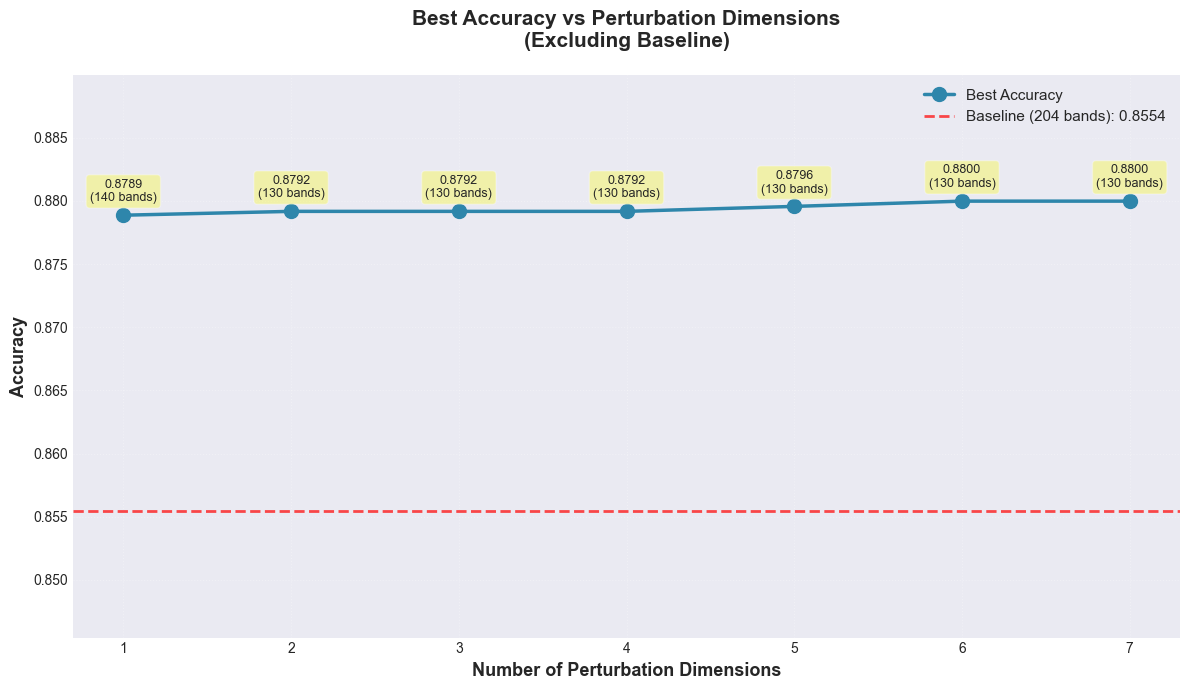


Insights:
- Best overall accuracy: 0.8800 at 6 dimensions
- Worst best accuracy: 0.8789 at 1 dimensions
- Range: 0.0011

- 7 perturbation dimension(s) achieved accuracy > baseline:
  * 1 dims: 0.8789 (+2.74%) with 140 bands
  * 2 dims: 0.8792 (+2.77%) with 130 bands
  * 3 dims: 0.8792 (+2.77%) with 130 bands
  * 4 dims: 0.8792 (+2.77%) with 130 bands
  * 5 dims: 0.8796 (+2.82%) with 130 bands
  * 6 dims: 0.8800 (+2.87%) with 130 bands
  * 7 dims: 0.8800 (+2.87%) with 130 bands


In [17]:
def plot_best_accuracy_vs_dimensions(best_df: pd.DataFrame, baseline_acc: float):
    """
    Plot best accuracy achieved for each perturbation dimension.
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot best accuracy line
    ax.plot(best_df['perturbation_dim'], best_df['accuracy'], 
            marker='o', linewidth=2.5, markersize=10, 
            label='Best Accuracy', color='#2E86AB', zorder=3)
    
    # Add baseline reference line
    ax.axhline(y=baseline_acc, color='red', linestyle='--', 
               linewidth=2, label=f'Baseline (204 bands): {baseline_acc:.4f}', 
               zorder=2, alpha=0.7)
    
    # Add value labels on points
    for idx, row in best_df.iterrows():
        ax.annotate(f"{row['accuracy']:.4f}\n({int(row['n_bands'])} bands)",
                   xy=(row['perturbation_dim'], row['accuracy']),
                   xytext=(0, 10), textcoords='offset points',
                   ha='center', fontsize=9, 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))
    
    # Styling
    ax.set_xlabel('Number of Perturbation Dimensions', fontsize=13, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
    ax.set_title('Best Accuracy vs Perturbation Dimensions\n(Excluding Baseline)', 
                fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(DIMENSION_LEVELS)
    ax.grid(True, alpha=0.3, linestyle=':')
    ax.legend(fontsize=11, loc='best', framealpha=0.9)
    
    # Set y-axis limits to show variation better
    y_min = min(best_df['accuracy'].min(), baseline_acc) - 0.01
    y_max = max(best_df['accuracy'].max(), baseline_acc) + 0.01
    ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'plot1_best_accuracy_vs_dimensions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print insights
    print("\nInsights:")
    print(f"- Best overall accuracy: {best_df['accuracy'].max():.4f} at {best_df.loc[best_df['accuracy'].idxmax(), 'perturbation_dim']} dimensions")
    print(f"- Worst best accuracy: {best_df['accuracy'].min():.4f} at {best_df.loc[best_df['accuracy'].idxmin(), 'perturbation_dim']} dimensions")
    print(f"- Range: {(best_df['accuracy'].max() - best_df['accuracy'].min()):.4f}")
    
    # Check if any beat baseline
    beat_baseline = best_df[best_df['accuracy'] > baseline_acc]
    if len(beat_baseline) > 0:
        print(f"\n- {len(beat_baseline)} perturbation dimension(s) achieved accuracy > baseline:")
        for _, row in beat_baseline.iterrows():
            improvement = (row['accuracy'] - baseline_acc) / baseline_acc * 100
            print(f"  * {int(row['perturbation_dim'])} dims: {row['accuracy']:.4f} (+{improvement:.2f}%) with {int(row['n_bands'])} bands")

# Generate plot
plot_best_accuracy_vs_dimensions(best_df, baseline_accuracy)

## 4. Plot 2: Tolerance Region Analysis

This plot shows the minimum number of bands needed to achieve different tolerance levels relative to the baseline.

In [18]:
def calculate_tolerance_bands(df: pd.DataFrame, baseline_acc: float, tolerance_levels: List[float]) -> pd.DataFrame:
    """
    For each perturbation dimension and tolerance level, find minimum bands needed.
    
    Args:
        df: Results DataFrame
        baseline_acc: Baseline accuracy
        tolerance_levels: List of tolerance percentages (e.g., [0.95, 0.97, 0.99])
    
    Returns:
        DataFrame with minimum bands for each dimension and tolerance level
    """
    results = []
    
    # Exclude baseline
    non_baseline = df[df['config_name'] != 'BASELINE_FULL_DATA'].copy()
    
    for dim in DIMENSION_LEVELS:
        dim_data = non_baseline[non_baseline['perturbation_dim'] == dim].copy()
        
        for tolerance in tolerance_levels:
            threshold = baseline_acc * tolerance
            
            # Find configurations that meet threshold
            valid_configs = dim_data[dim_data['accuracy'] >= threshold]
            
            if len(valid_configs) > 0:
                # Find minimum bands
                min_bands_idx = valid_configs['n_bands'].idxmin()
                min_bands_config = valid_configs.loc[min_bands_idx]
                
                results.append({
                    'perturbation_dim': dim,
                    'tolerance_pct': tolerance * 100,
                    'tolerance_label': f"{tolerance*100:.0f}%",
                    'threshold_accuracy': threshold,
                    'min_bands': min_bands_config['n_bands'],
                    'achieved_accuracy': min_bands_config['accuracy'],
                    'config_name': min_bands_config['config_name']
                })
            else:
                # No configuration meets threshold
                results.append({
                    'perturbation_dim': dim,
                    'tolerance_pct': tolerance * 100,
                    'tolerance_label': f"{tolerance*100:.0f}%",
                    'threshold_accuracy': threshold,
                    'min_bands': None,
                    'achieved_accuracy': None,
                    'config_name': None
                })
    
    return pd.DataFrame(results)

# Define tolerance levels
TOLERANCE_LEVELS = [0.95, 0.97, 0.99]  # 95%, 97%, 99% of baseline

# Calculate tolerance bands
tolerance_df = calculate_tolerance_bands(all_results, baseline_accuracy, TOLERANCE_LEVELS)

print("\nTolerance Region Analysis:")
print("=" * 80)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}\n")

for tol in TOLERANCE_LEVELS:
    print(f"\nTolerance Level: {tol*100:.0f}% (Threshold: {baseline_accuracy * tol:.4f})")
    tol_data = tolerance_df[tolerance_df['tolerance_pct'] == tol * 100]
    print(tol_data[['perturbation_dim', 'min_bands', 'achieved_accuracy', 'config_name']].to_string(index=False))


Tolerance Region Analysis:
Baseline Accuracy: 0.8554


Tolerance Level: 95% (Threshold: 0.8127)
 perturbation_dim  min_bands  achieved_accuracy                        config_name
                1          4           0.813061 mmr_lambda050_variance_1dim_4bands
                2          4           0.813061 mmr_lambda050_variance_1dim_4bands
                3          4           0.813061 mmr_lambda050_variance_1dim_4bands
                4          4           0.813061 mmr_lambda050_variance_1dim_4bands
                5          4           0.813061 mmr_lambda050_variance_1dim_4bands
                6          4           0.813061 mmr_lambda050_variance_1dim_4bands
                7          4           0.813061 mmr_lambda050_variance_1dim_4bands

Tolerance Level: 97% (Threshold: 0.8298)
 perturbation_dim  min_bands  achieved_accuracy                         config_name
                1         12           0.830870 mmr_lambda050_variance_1dim_12bands
                2         11 

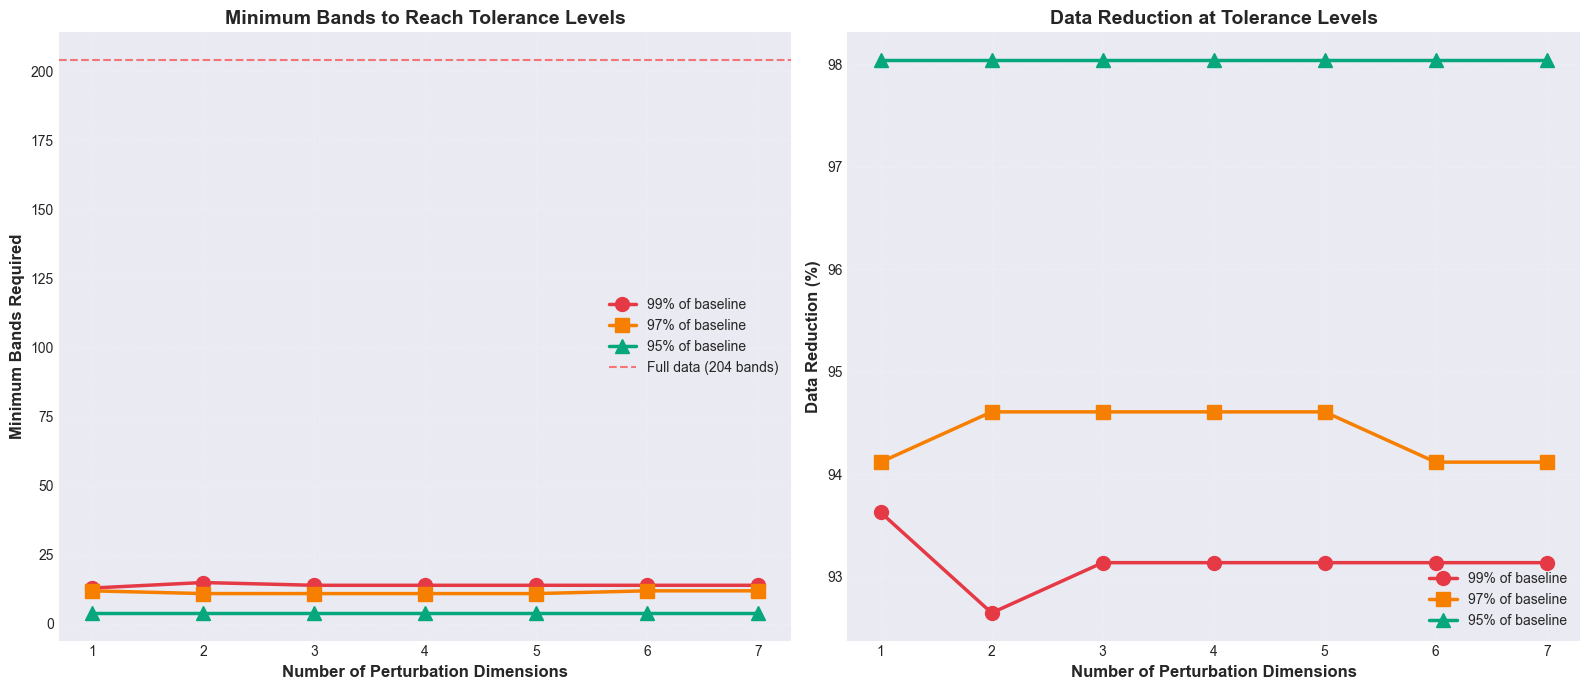


Tolerance Region Insights:

99% tolerance (>= 0.8469 accuracy):
  - Best: 13 bands at 1 perturbation dimensions
  - Data reduction: 93.6%

97% tolerance (>= 0.8298 accuracy):
  - Best: 11 bands at 2 perturbation dimensions
  - Data reduction: 94.6%

95% tolerance (>= 0.8127 accuracy):
  - Best: 4 bands at 1 perturbation dimensions
  - Data reduction: 98.0%


In [19]:
def plot_tolerance_regions(tolerance_df: pd.DataFrame, baseline_acc: float):
    """
    Plot minimum bands needed for each tolerance level across perturbation dimensions.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Minimum bands needed
    colors = ['#E63946', '#F77F00', '#06A77D']
    markers = ['o', 's', '^']
    
    for idx, (tol_label, color, marker) in enumerate(zip(
        sorted(tolerance_df['tolerance_label'].unique(), reverse=True), colors, markers)):
        
        tol_data = tolerance_df[tolerance_df['tolerance_label'] == tol_label]
        tol_data_valid = tol_data[tol_data['min_bands'].notna()]
        
        ax1.plot(tol_data_valid['perturbation_dim'], tol_data_valid['min_bands'],
                marker=marker, linewidth=2.5, markersize=10, 
                label=f'{tol_label} of baseline', color=color)
    
    ax1.axhline(y=204, color='red', linestyle='--', linewidth=1.5, 
               label='Full data (204 bands)', alpha=0.5)
    
    ax1.set_xlabel('Number of Perturbation Dimensions', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Minimum Bands Required', fontsize=12, fontweight='bold')
    ax1.set_title('Minimum Bands to Reach Tolerance Levels', fontsize=14, fontweight='bold')
    ax1.set_xticks(DIMENSION_LEVELS)
    ax1.grid(True, alpha=0.3, linestyle=':')
    ax1.legend(fontsize=10, loc='best')
    
    # Plot 2: Data reduction achieved
    for idx, (tol_label, color, marker) in enumerate(zip(
        sorted(tolerance_df['tolerance_label'].unique(), reverse=True), colors, markers)):
        
        tol_data = tolerance_df[tolerance_df['tolerance_label'] == tol_label]
        tol_data_valid = tol_data[tol_data['min_bands'].notna()].copy()
        
        # Calculate data reduction percentage
        tol_data_valid['reduction_pct'] = (1 - tol_data_valid['min_bands'] / 204) * 100
        
        ax2.plot(tol_data_valid['perturbation_dim'], tol_data_valid['reduction_pct'],
                marker=marker, linewidth=2.5, markersize=10, 
                label=f'{tol_label} of baseline', color=color)
    
    ax2.set_xlabel('Number of Perturbation Dimensions', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Data Reduction (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Data Reduction at Tolerance Levels', fontsize=14, fontweight='bold')
    ax2.set_xticks(DIMENSION_LEVELS)
    ax2.grid(True, alpha=0.3, linestyle=':')
    ax2.legend(fontsize=10, loc='best')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'plot2_tolerance_region_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print insights
    print("\nTolerance Region Insights:")
    for tol in sorted(TOLERANCE_LEVELS, reverse=True):
        tol_data = tolerance_df[tolerance_df['tolerance_pct'] == tol * 100]
        tol_data_valid = tol_data[tol_data['min_bands'].notna()]
        
        if len(tol_data_valid) > 0:
            min_bands = tol_data_valid['min_bands'].min()
            best_dim = tol_data_valid.loc[tol_data_valid['min_bands'].idxmin(), 'perturbation_dim']
            reduction = (1 - min_bands / 204) * 100
            
            print(f"\n{tol*100:.0f}% tolerance (>= {baseline_acc * tol:.4f} accuracy):")
            print(f"  - Best: {int(min_bands)} bands at {int(best_dim)} perturbation dimensions")
            print(f"  - Data reduction: {reduction:.1f}%")

# Generate plot
plot_tolerance_regions(tolerance_df, baseline_accuracy)

## 5. Plot 3: Difference from Baseline

This plot shows the accuracy difference (delta) between best configurations and baseline for each perturbation dimension.

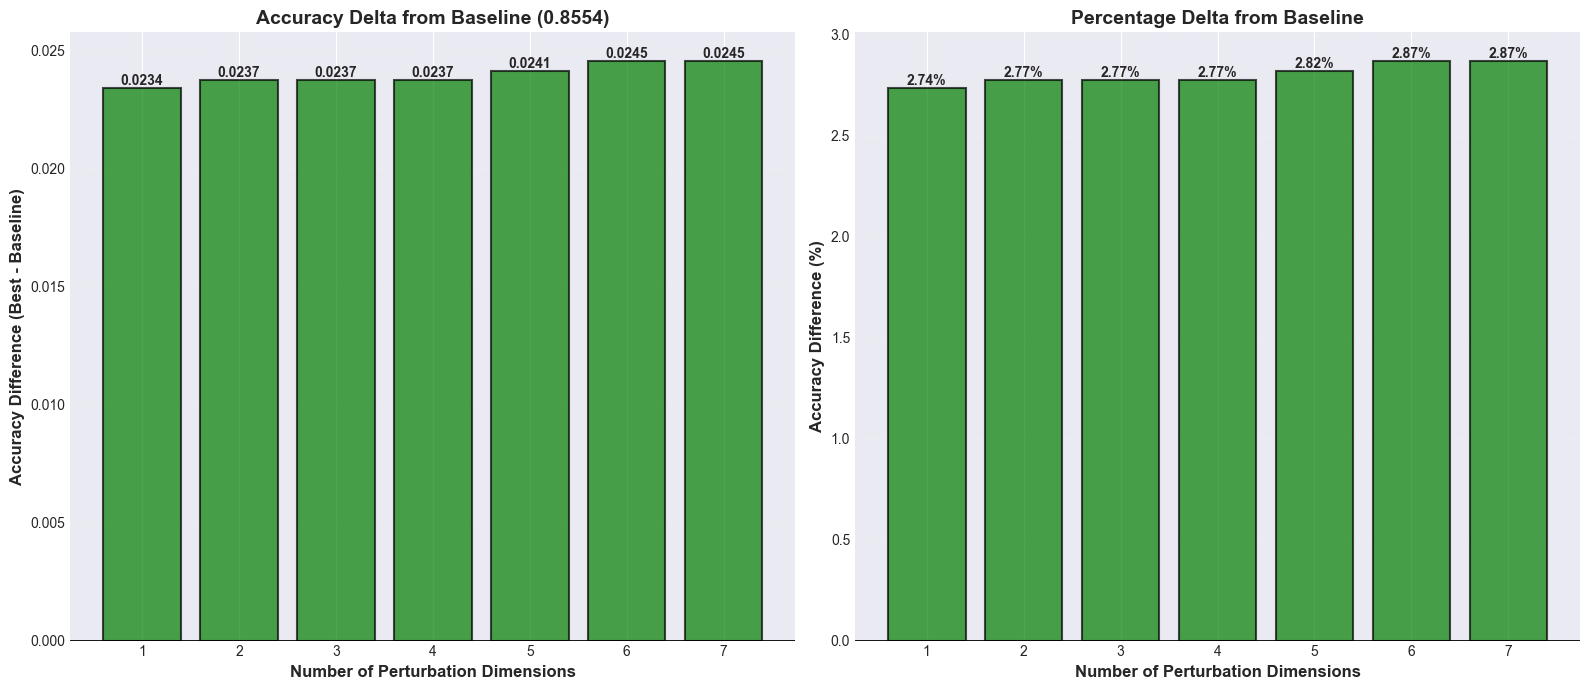


Difference from Baseline Insights:
Baseline: 0.8554

1 dims: +0.0234 (+2.74%) - better with 140 bands
2 dims: +0.0237 (+2.77%) - better with 130 bands
3 dims: +0.0237 (+2.77%) - better with 130 bands
4 dims: +0.0237 (+2.77%) - better with 130 bands
5 dims: +0.0241 (+2.82%) - better with 130 bands
6 dims: +0.0245 (+2.87%) - better with 130 bands
7 dims: +0.0245 (+2.87%) - better with 130 bands


In [20]:
def plot_difference_from_baseline(best_df: pd.DataFrame, baseline_acc: float):
    """
    Plot accuracy difference between best configs and baseline.
    """
    # Calculate differences
    best_df_plot = best_df.copy()
    best_df_plot['acc_diff'] = best_df_plot['accuracy'] - baseline_acc
    best_df_plot['acc_diff_pct'] = (best_df_plot['acc_diff'] / baseline_acc) * 100
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Absolute difference
    colors = ['green' if x >= 0 else 'red' for x in best_df_plot['acc_diff']]
    bars1 = ax1.bar(best_df_plot['perturbation_dim'], best_df_plot['acc_diff'], 
                    color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, val in zip(bars1, best_df_plot['acc_diff']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom' if height >= 0 else 'top', 
                fontsize=10, fontweight='bold')
    
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=2)
    ax1.set_xlabel('Number of Perturbation Dimensions', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy Difference (Best - Baseline)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Accuracy Delta from Baseline ({baseline_acc:.4f})', 
                 fontsize=14, fontweight='bold')
    ax1.set_xticks(DIMENSION_LEVELS)
    ax1.grid(True, alpha=0.3, linestyle=':', axis='y')
    
    # Plot 2: Percentage difference
    colors2 = ['green' if x >= 0 else 'red' for x in best_df_plot['acc_diff_pct']]
    bars2 = ax2.bar(best_df_plot['perturbation_dim'], best_df_plot['acc_diff_pct'], 
                    color=colors2, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, val in zip(bars2, best_df_plot['acc_diff_pct']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}%',
                ha='center', va='bottom' if height >= 0 else 'top', 
                fontsize=10, fontweight='bold')
    
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=2)
    ax2.set_xlabel('Number of Perturbation Dimensions', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy Difference (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Percentage Delta from Baseline', fontsize=14, fontweight='bold')
    ax2.set_xticks(DIMENSION_LEVELS)
    ax2.grid(True, alpha=0.3, linestyle=':', axis='y')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'plot3_difference_from_baseline.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print insights
    print("\nDifference from Baseline Insights:")
    print(f"Baseline: {baseline_acc:.4f}\n")
    
    for _, row in best_df_plot.iterrows():
        dim = int(row['perturbation_dim'])
        diff = row['acc_diff']
        diff_pct = row['acc_diff_pct']
        bands = int(row['n_bands'])
        
        direction = "better" if diff > 0 else "worse"
        print(f"{dim} dims: {diff:+.4f} ({diff_pct:+.2f}%) - {direction} with {bands} bands")

# Generate plot
plot_difference_from_baseline(best_df, baseline_accuracy)

## 6. Additional Analysis & Visualizations

### 6.1 Accuracy Distribution by Perturbation Dimension

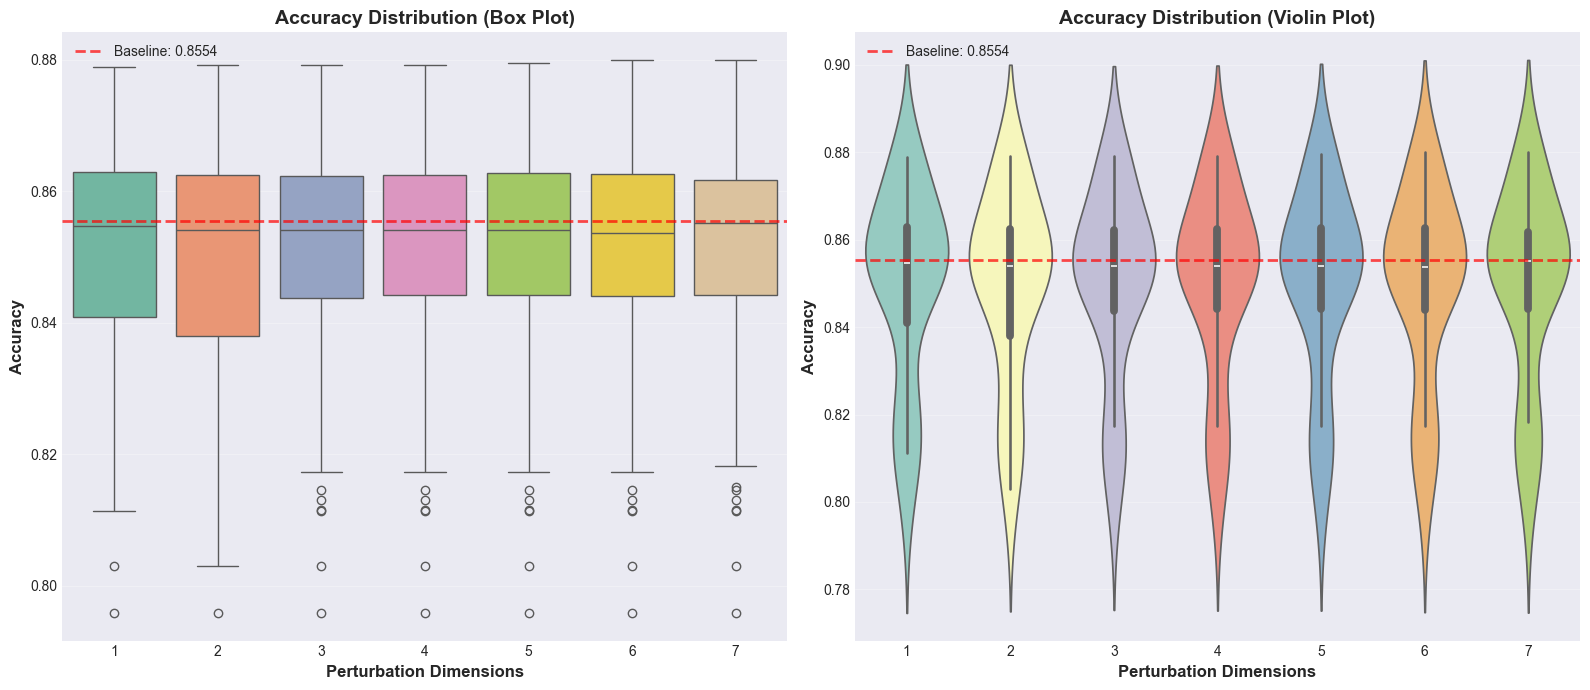

In [21]:
def plot_accuracy_distributions(df: pd.DataFrame, baseline_acc: float):
    """
    Plot accuracy distributions for each perturbation dimension using box plots and violin plots.
    """
    non_baseline = df[df['config_name'] != 'BASELINE_FULL_DATA']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Box plot
    sns.boxplot(data=non_baseline, x='perturbation_dim', y='accuracy', 
                palette='Set2', ax=ax1)
    ax1.axhline(y=baseline_acc, color='red', linestyle='--', 
               linewidth=2, label=f'Baseline: {baseline_acc:.4f}', alpha=0.7)
    ax1.set_xlabel('Perturbation Dimensions', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Accuracy Distribution (Box Plot)', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Violin plot
    sns.violinplot(data=non_baseline, x='perturbation_dim', y='accuracy', 
                   palette='Set3', ax=ax2, inner='box')
    ax2.axhline(y=baseline_acc, color='red', linestyle='--', 
               linewidth=2, label=f'Baseline: {baseline_acc:.4f}', alpha=0.7)
    ax2.set_xlabel('Perturbation Dimensions', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Accuracy Distribution (Violin Plot)', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'plot4_accuracy_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_accuracy_distributions(all_results, baseline_accuracy)

### 6.2 Accuracy vs Number of Bands (Pareto Front)

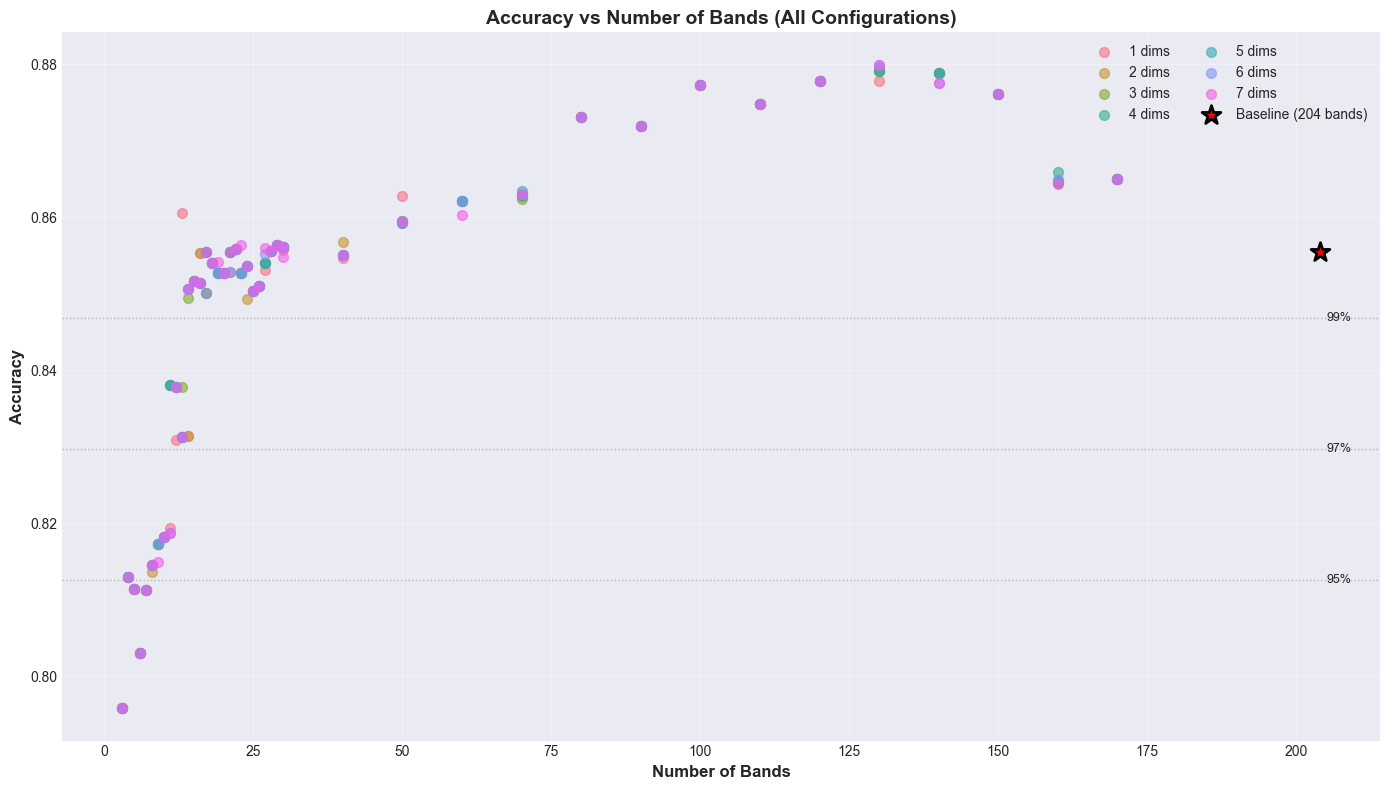

In [22]:
def plot_accuracy_vs_bands_pareto(df: pd.DataFrame, baseline_acc: float):
    """
    Plot accuracy vs number of bands for all perturbation dimensions.
    Show the trade-off between feature reduction and accuracy.
    """
    non_baseline = df[df['config_name'] != 'BASELINE_FULL_DATA']
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot each perturbation dimension with different color
    colors = sns.color_palette('husl', len(DIMENSION_LEVELS))
    
    for dim, color in zip(DIMENSION_LEVELS, colors):
        dim_data = non_baseline[non_baseline['perturbation_dim'] == dim]
        ax.scatter(dim_data['n_bands'], dim_data['accuracy'], 
                  label=f'{dim} dims', alpha=0.6, s=50, color=color)
    
    # Add baseline point
    ax.scatter([204], [baseline_acc], color='red', s=200, marker='*', 
              label='Baseline (204 bands)', zorder=5, edgecolor='black', linewidth=2)
    
    # Add tolerance lines
    for tol in [0.95, 0.97, 0.99]:
        ax.axhline(y=baseline_acc * tol, color='gray', linestyle=':', 
                  alpha=0.5, linewidth=1)
        ax.text(205, baseline_acc * tol, f'{tol*100:.0f}%', 
               fontsize=9, va='center')
    
    ax.set_xlabel('Number of Bands', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Accuracy vs Number of Bands (All Configurations)', 
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best', ncol=2)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'plot5_accuracy_vs_bands_pareto.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_accuracy_vs_bands_pareto(all_results, baseline_accuracy)

### 6.3 Efficiency Analysis: Accuracy per Band

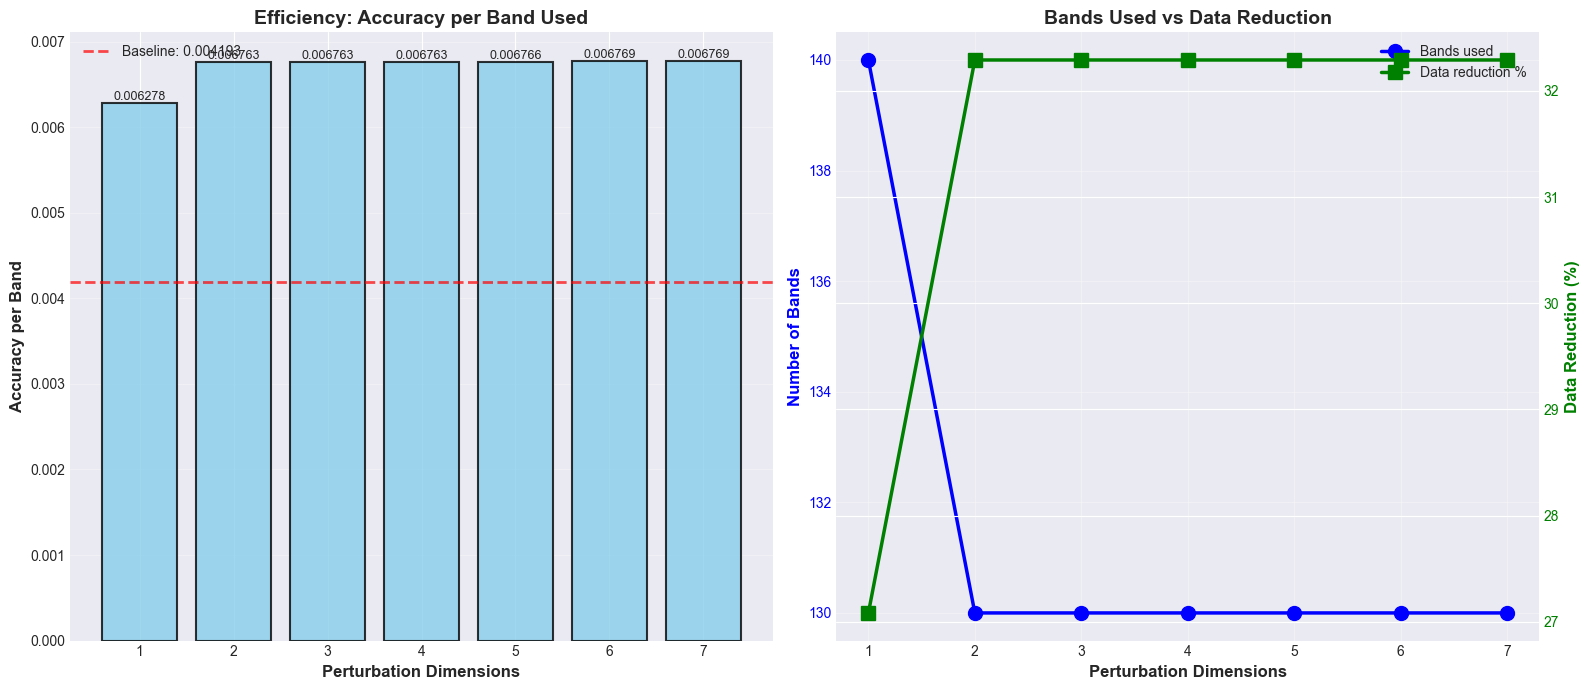


Efficiency Analysis:
Baseline efficiency: 0.004193 accuracy per band

1 dims: 0.006278 acc/band (+49.70% vs baseline)
2 dims: 0.006763 acc/band (+61.28% vs baseline)
3 dims: 0.006763 acc/band (+61.28% vs baseline)
4 dims: 0.006763 acc/band (+61.28% vs baseline)
5 dims: 0.006766 acc/band (+61.35% vs baseline)
6 dims: 0.006769 acc/band (+61.42% vs baseline)
7 dims: 0.006769 acc/band (+61.42% vs baseline)


In [23]:
def plot_efficiency_analysis(best_df: pd.DataFrame, baseline_acc: float):
    """
    Analyze efficiency: accuracy achieved per band used.
    """
    best_df_plot = best_df.copy()
    best_df_plot['acc_per_band'] = best_df_plot['accuracy'] / best_df_plot['n_bands']
    baseline_acc_per_band = baseline_acc / 204
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Accuracy per band
    bars = ax1.bar(best_df_plot['perturbation_dim'], best_df_plot['acc_per_band'], 
                   color='skyblue', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax1.axhline(y=baseline_acc_per_band, color='red', linestyle='--', 
               linewidth=2, label=f'Baseline: {baseline_acc_per_band:.6f}', alpha=0.7)
    
    for bar, val in zip(bars, best_df_plot['acc_per_band']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.6f}',
                ha='center', va='bottom', fontsize=9)
    
    ax1.set_xlabel('Perturbation Dimensions', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy per Band', fontsize=12, fontweight='bold')
    ax1.set_title('Efficiency: Accuracy per Band Used', fontsize=14, fontweight='bold')
    ax1.set_xticks(DIMENSION_LEVELS)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Bands needed and data reduction
    ax2_twin = ax2.twinx()
    
    line1 = ax2.plot(best_df_plot['perturbation_dim'], best_df_plot['n_bands'], 
                     marker='o', linewidth=2.5, markersize=10, 
                     label='Bands used', color='blue')
    
    line2 = ax2_twin.plot(best_df_plot['perturbation_dim'], 
                          best_df_plot['data_reduction_pct'], 
                          marker='s', linewidth=2.5, markersize=10, 
                          label='Data reduction %', color='green')
    
    ax2.set_xlabel('Perturbation Dimensions', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Bands', fontsize=12, fontweight='bold', color='blue')
    ax2_twin.set_ylabel('Data Reduction (%)', fontsize=12, fontweight='bold', color='green')
    ax2.set_title('Bands Used vs Data Reduction', fontsize=14, fontweight='bold')
    ax2.set_xticks(DIMENSION_LEVELS)
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2_twin.tick_params(axis='y', labelcolor='green')
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, loc='best')
    
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'plot6_efficiency_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print insights
    print("\nEfficiency Analysis:")
    print(f"Baseline efficiency: {baseline_acc_per_band:.6f} accuracy per band\n")
    
    for _, row in best_df_plot.iterrows():
        dim = int(row['perturbation_dim'])
        eff = row['acc_per_band']
        improvement = ((eff - baseline_acc_per_band) / baseline_acc_per_band) * 100
        print(f"{dim} dims: {eff:.6f} acc/band ({improvement:+.2f}% vs baseline)")

plot_efficiency_analysis(best_df, baseline_accuracy)

### 6.4 Heatmap: Accuracy Across Dimensions and Band Counts

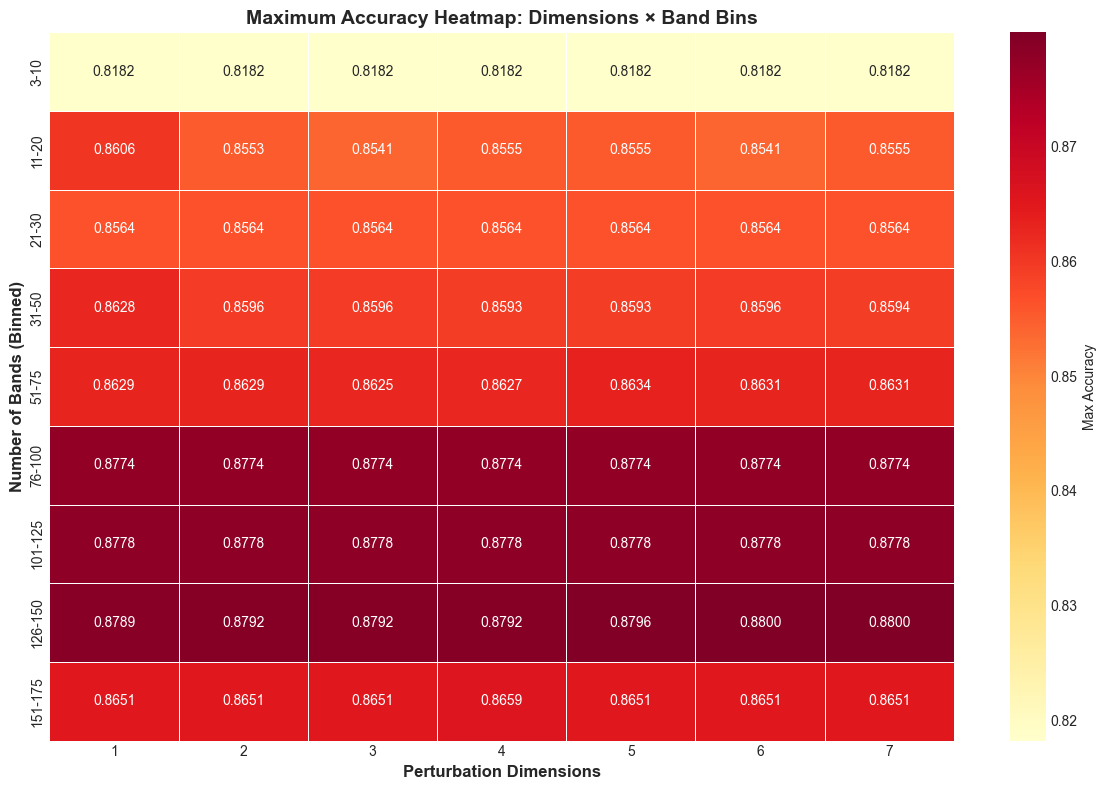

In [24]:
def plot_accuracy_heatmap(df: pd.DataFrame):
    """
    Create a heatmap showing accuracy across perturbation dimensions and band bins.
    """
    non_baseline = df[df['config_name'] != 'BASELINE_FULL_DATA'].copy()
    
    # Create band bins
    bins = [0, 10, 20, 30, 50, 75, 100, 125, 150, 175, 204]
    labels = ['3-10', '11-20', '21-30', '31-50', '51-75', '76-100', 
              '101-125', '126-150', '151-175', '176-204']
    non_baseline['band_bin'] = pd.cut(non_baseline['n_bands'], bins=bins, labels=labels)
    
    # Pivot table for heatmap
    pivot_table = non_baseline.pivot_table(
        values='accuracy', 
        index='band_bin', 
        columns='perturbation_dim',
        aggfunc='max'
    )
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='YlOrRd', 
                cbar_kws={'label': 'Max Accuracy'}, ax=ax, linewidths=0.5)
    
    ax.set_xlabel('Perturbation Dimensions', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Bands (Binned)', fontsize=12, fontweight='bold')
    ax.set_title('Maximum Accuracy Heatmap: Dimensions × Band Bins', 
                fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'plot7_accuracy_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_accuracy_heatmap(all_results)

### 6.5 Stability Analysis: Coefficient of Variation

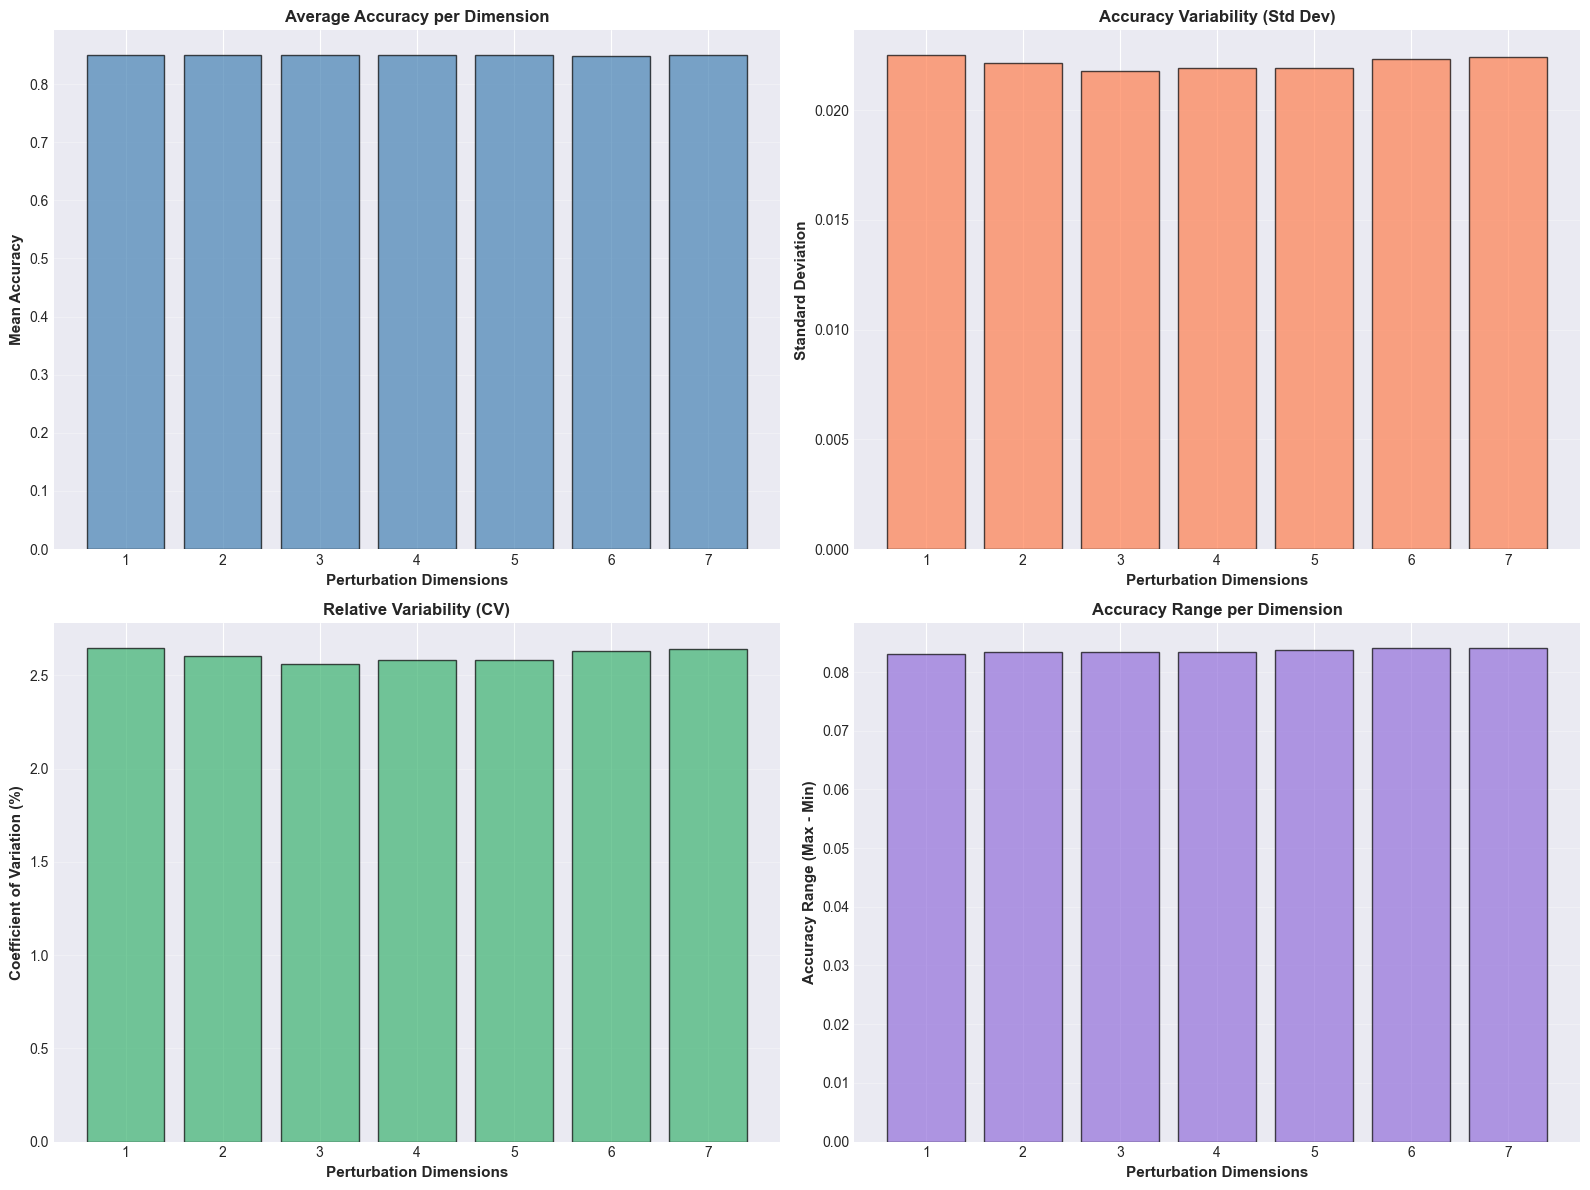


Stability Analysis:
 perturbation_dim  mean_accuracy  std_accuracy  cv_accuracy  range_accuracy  count
                1       0.849364      0.022502     2.649302        0.083038     43
                2       0.849135      0.022122     2.605250        0.083342     43
                3       0.849686      0.021783     2.563634        0.083342     43
                4       0.849718      0.021933     2.581157        0.083342     43
                5       0.849715      0.021935     2.581432        0.083735     43
                6       0.849091      0.022320     2.628669        0.084151     43
                7       0.849268      0.022426     2.640650        0.084151     43

Most stable: 3 dims (CV: 2.56%)
Least stable: 1 dims (CV: 2.65%)


In [25]:
def plot_stability_analysis(df: pd.DataFrame):
    """
    Analyze stability: how consistent are results within each perturbation dimension?
    """
    non_baseline = df[df['config_name'] != 'BASELINE_FULL_DATA']
    
    stability_metrics = []
    for dim in DIMENSION_LEVELS:
        dim_data = non_baseline[non_baseline['perturbation_dim'] == dim]
        
        stability_metrics.append({
            'perturbation_dim': dim,
            'mean_accuracy': dim_data['accuracy'].mean(),
            'std_accuracy': dim_data['accuracy'].std(),
            'cv_accuracy': (dim_data['accuracy'].std() / dim_data['accuracy'].mean()) * 100,
            'range_accuracy': dim_data['accuracy'].max() - dim_data['accuracy'].min(),
            'count': len(dim_data)
        })
    
    stability_df = pd.DataFrame(stability_metrics)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Mean accuracy
    ax1.bar(stability_df['perturbation_dim'], stability_df['mean_accuracy'], 
           color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Perturbation Dimensions', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Mean Accuracy', fontsize=11, fontweight='bold')
    ax1.set_title('Average Accuracy per Dimension', fontsize=12, fontweight='bold')
    ax1.set_xticks(DIMENSION_LEVELS)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Standard deviation
    ax2.bar(stability_df['perturbation_dim'], stability_df['std_accuracy'], 
           color='coral', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Perturbation Dimensions', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Standard Deviation', fontsize=11, fontweight='bold')
    ax2.set_title('Accuracy Variability (Std Dev)', fontsize=12, fontweight='bold')
    ax2.set_xticks(DIMENSION_LEVELS)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Coefficient of variation
    ax3.bar(stability_df['perturbation_dim'], stability_df['cv_accuracy'], 
           color='mediumseagreen', alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Perturbation Dimensions', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Coefficient of Variation (%)', fontsize=11, fontweight='bold')
    ax3.set_title('Relative Variability (CV)', fontsize=12, fontweight='bold')
    ax3.set_xticks(DIMENSION_LEVELS)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Range
    ax4.bar(stability_df['perturbation_dim'], stability_df['range_accuracy'], 
           color='mediumpurple', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Perturbation Dimensions', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Accuracy Range (Max - Min)', fontsize=11, fontweight='bold')
    ax4.set_title('Accuracy Range per Dimension', fontsize=12, fontweight='bold')
    ax4.set_xticks(DIMENSION_LEVELS)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'plot8_stability_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nStability Analysis:")
    print("=" * 80)
    print(stability_df.to_string(index=False))
    
    # Insights
    most_stable = stability_df.loc[stability_df['cv_accuracy'].idxmin()]
    least_stable = stability_df.loc[stability_df['cv_accuracy'].idxmax()]
    
    print(f"\nMost stable: {int(most_stable['perturbation_dim'])} dims (CV: {most_stable['cv_accuracy']:.2f}%)")
    print(f"Least stable: {int(least_stable['perturbation_dim'])} dims (CV: {least_stable['cv_accuracy']:.2f}%)")

plot_stability_analysis(all_results)

## 7. Summary and Recommendations

### Key Findings

In [26]:
print("="*80)
print("SUMMARY OF PERTURBATION DIMENSION ANALYSIS")
print("="*80)

print(f"\n1. BASELINE REFERENCE")
print(f"   - Accuracy: {baseline_accuracy:.4f}")
print(f"   - Bands: 204 (full dataset)")

print(f"\n2. BEST CONFIGURATIONS BY DIMENSION")
for _, row in best_df.iterrows():
    dim = int(row['perturbation_dim'])
    acc = row['accuracy']
    bands = int(row['n_bands'])
    reduction = row['data_reduction_pct']
    delta = acc - baseline_accuracy
    
    print(f"   {dim} dims: Acc={acc:.4f} ({delta:+.4f}), Bands={bands}, Reduction={reduction:.1f}%")

print(f"\n3. OPTIMAL DIMENSION LEVEL")
best_overall_idx = best_df['accuracy'].idxmax()
best_overall = best_df.loc[best_overall_idx]
print(f"   - Best accuracy: {int(best_overall['perturbation_dim'])} perturbation dimensions")
print(f"   - Accuracy: {best_overall['accuracy']:.4f}")
print(f"   - Bands: {int(best_overall['n_bands'])}")
print(f"   - Improvement over baseline: {((best_overall['accuracy'] - baseline_accuracy) / baseline_accuracy * 100):+.2f}%")

print(f"\n4. MOST EFFICIENT (Best accuracy per band)")
best_df_eff = best_df.copy()
best_df_eff['acc_per_band'] = best_df_eff['accuracy'] / best_df_eff['n_bands']
most_efficient_idx = best_df_eff['acc_per_band'].idxmax()
most_efficient = best_df_eff.loc[most_efficient_idx]
print(f"   - {int(most_efficient['perturbation_dim'])} dimensions")
print(f"   - Efficiency: {most_efficient['acc_per_band']:.6f} acc/band")
print(f"   - Baseline efficiency: {baseline_accuracy/204:.6f} acc/band")

print(f"\n5. DATA REDUCTION POTENTIAL")
for tol in [0.99, 0.97, 0.95]:
    tol_data = tolerance_df[tolerance_df['tolerance_pct'] == tol * 100]
    tol_data_valid = tol_data[tol_data['min_bands'].notna()]
    
    if len(tol_data_valid) > 0:
        best_reduction_idx = tol_data_valid['min_bands'].idxmin()
        best_reduction = tol_data_valid.loc[best_reduction_idx]
        reduction_pct = (1 - best_reduction['min_bands'] / 204) * 100
        
        print(f"   {tol*100:.0f}% of baseline ({baseline_accuracy * tol:.4f}):")
        print(f"      - Minimum {int(best_reduction['min_bands'])} bands at {int(best_reduction['perturbation_dim'])} dims")
        print(f"      - Data reduction: {reduction_pct:.1f}%")

print(f"\n6. RECOMMENDATIONS")
print(f"   - For maximum accuracy: Use {int(best_overall['perturbation_dim'])} perturbation dimensions")
print(f"   - For efficiency: Use {int(most_efficient['perturbation_dim'])} perturbation dimensions")
print(f"   - For balance: Examine tolerance regions to find optimal trade-off")

print("\n" + "="*80)

SUMMARY OF PERTURBATION DIMENSION ANALYSIS

1. BASELINE REFERENCE
   - Accuracy: 0.8554
   - Bands: 204 (full dataset)

2. BEST CONFIGURATIONS BY DIMENSION
   1 dims: Acc=0.8789 (+0.0234), Bands=140, Reduction=27.1%
   2 dims: Acc=0.8792 (+0.0237), Bands=130, Reduction=32.3%
   3 dims: Acc=0.8792 (+0.0237), Bands=130, Reduction=32.3%
   4 dims: Acc=0.8792 (+0.0237), Bands=130, Reduction=32.3%
   5 dims: Acc=0.8796 (+0.0241), Bands=130, Reduction=32.3%
   6 dims: Acc=0.8800 (+0.0245), Bands=130, Reduction=32.3%
   7 dims: Acc=0.8800 (+0.0245), Bands=130, Reduction=32.3%

3. OPTIMAL DIMENSION LEVEL
   - Best accuracy: 6 perturbation dimensions
   - Accuracy: 0.8800
   - Bands: 130
   - Improvement over baseline: +2.87%

4. MOST EFFICIENT (Best accuracy per band)
   - 6 dimensions
   - Efficiency: 0.006769 acc/band
   - Baseline efficiency: 0.004193 acc/band

5. DATA REDUCTION POTENTIAL
   99% of baseline (0.8469):
      - Minimum 13 bands at 1 dims
      - Data reduction: 93.6%
   97% of

## 8. Additional Brainstormed Visualizations

### Discussion Points:

1. **Correlation Analysis**: Does increasing perturbation dimensions lead to more intelligent layer picking?
   - We can measure this by looking at:
     - Consistency across band counts (stability)
     - Peak accuracy achieved
     - Efficiency metrics

2. **Quality of Selection**: How to measure "intelligence" of wavelength selection?
   - Higher accuracy with fewer bands = better intelligence
   - Smaller variance in accuracy = more stable/reliable selection
   - Better tolerance region performance = smarter dimensionality reduction

3. **Other Visualization Ideas**:
   - 3D surface plot: Dimensions × Bands × Accuracy
   - Time analysis: Selection time vs accuracy trade-off
   - Clustering quality metrics (ARI, NMI) vs perturbation dimensions
   - Per-class accuracy breakdown by dimension
   - ROI-specific accuracy trends

Would you like me to implement any of these additional visualizations?